# Capstone Project 1
## Data Wrangling Steps
The Seeds data set can be found on the UCI ML Repository at https://archive.ics.uci.edu/ml/datasets/seeds. It is simple to download and has a description of the parameters. Upon inspection it is clear that compared to most data sets in use today, this set is very small. There are 210 data points and 8 variables. Seven of these variables are numeric and essentially continuous; they are geometric properties of the seeds taken from precise measurement. The final variable is categorical, and gives the species of the seed with three distinct values: 1="Kama", 2="Rosa", 3="Canadian". The size of the dataset might be one of the challenges to be dealt with. A number of ways to address this have been considered, including cross-validation, bootstrapping, and creating synthetic data.

There are no missing values. There is, however, a mismatch of data in correct columns. After inspecting the original text file, the mismatched columns were easy to see. Some of the entries had, in random places, been shifted over to the right a column or two, leaving blank spaces where the information should be. This misalignment was present in about 5% of the row entries, and and causes an error when attempting to load the file directly into a pandas dataframe. Skipping these rows, the file can be read into a dataframe with 11 missing entries.

Certain outliers for each class are seen when the data is visualized in a box plot. In a scatter plot, clear clusters emerge for each class, but there are about 5 anomalies that breach the class decision boundary and lie in the area for another class. These “outliers” will likely be best dealt with by using hyper-parameter tuning and cross validation. Adding enough nodes in a neural network may help the algorithm classify the outliers properly using other features with which to compare. They are left in the data to provide an accurate sampling of the range of geometric properties for each plant species.

To extend the size of the dataset, the distributions of each variable can be approximated, and a random sample drawn from these distributions, simulating a new data point. Doing this thousands of times and checking that the points lie within the known parameters will give more data with which the neural network can train. 


In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats 
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#Inspect the raw data:
with open('seeds_raw.txt','r') as file:
    for i in range(10):
        print(file.readline())

15.26	14.84	0.871	5.763	3.312	2.221	5.22	1

14.88	14.57	0.8811	5.554	3.333	1.018	4.956	1

14.29	14.09	0.905	5.291	3.337	2.699	4.825	1

13.84	13.94	0.8955	5.324	3.379	2.259	4.805	1

16.14	14.99	0.9034	5.658	3.562	1.355	5.175	1

14.38	14.21	0.8951	5.386	3.312	2.462	4.956	1

14.69	14.49	0.8799	5.563	3.259	3.586	5.219	1

14.11	14.1	0.8911	5.42	3.302	2.7		5		1

16.63	15.46	0.8747	6.053	3.465	2.04	5.877	1

16.44	15.25	0.888	5.884	3.505	1.969	5.533	1



The text file is tab delimited with some columns having misplaced entries. When attempting to load the file directly into a pandas dataframe, an error occurs:

In [3]:
seeds_df = pd.read_csv('seeds_raw.txt',sep='\t',header=None)

ParserError: Error tokenizing data. C error: Expected 8 fields in line 8, saw 10


In [ ]:
#The misaligned columns cause this error. Instructing the csv reader to ignore these errors allows the rest of the
#data to be loaded:
seeds_df = pd.read_table('seeds_raw.txt',sep='\t',header=None,\
                          error_bad_lines=False)
seeds_df.head(10)

In [ ]:
#However, we are now missing some data. Inspecting the data frame's info shows us we are missing 11 entries. With such a
#small initial data set, this amounts to a significant loss:
print(seeds_df.info(),'\nLoss of',round(11/210 * 100,2),'%')

The method above should be used for very large datasets where there are possibly thousands of misaligned columns and manual
cleaning may be very impractical. 

Because this data set is so small, and only 11 entries are misaligned, it is a simple task to go directly into 
the seeds_raw.txt file and fix the alignment manually. This is done and saved in the file seeds_dataset.txt.
The data description has also been copied into this file as an easily accesible record of the variable names.

In [4]:
with open('seeds_dataset.txt','r') as file:
    for i in range(20):
        print(file.readline())

seeds = pd.read_csv('seeds_dataset.txt',sep='\t',header=None,skiprows=(0,1,2,3,4,5,6,7,8,9,10,11))
seeds.head()

To construct the data, seven geometric parameters of wheat kernels were measured:

1. area A,

2. perimeter P,

3. compactness C = 4*pi*A/P^2,

4. length of kernel,

5. width of kernel,

6. asymmetry coefficient

7. length of kernel groove.

All of these parameters were real-valued continuous.

---------------------------------------------------------------------------------------





15.26	14.84	0.871	5.763	3.312	2.221	5.22	1

14.88	14.57	0.8811	5.554	3.333	1.018	4.956	1

14.29	14.09	0.905	5.291	3.337	2.699	4.825	1

13.84	13.94	0.8955	5.324	3.379	2.259	4.805	1

16.14	14.99	0.9034	5.658	3.562	1.355	5.175	1

14.38	14.21	0.8951	5.386	3.312	2.462	4.956	1

14.69	14.49	0.8799	5.563	3.259	3.586	5.219	1

14.11	14.1	0.8911	5.42	3.302	2.7	5	1



0      1       2      3      4      5      6  7
0  15.26  14.84  0.8710  5.763  3.312  2.221  5.220  1
1  14.88  14.57  0.8811  5.554  3.333  1.018  4.956  1
2  14.29  14.09  0.9050  5.291  3.337  2.699  4.825  1
3  13.84  13.94  0.8955  5.324  3.379  2.259  4.805  1
4  16.14  14.99  0.9034  5.658  3.562  1.355  5.175  1

In [5]:
#Inspecting the seeds dataframe shows us that all entries are now present. For best results this
#dataframe will be used, though we will perform hacker statistics on both the degraded and the full datasets for 
#comparison. 
seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       210 non-null    float64
 1   1       210 non-null    float64
 2   2       210 non-null    float64
 3   3       210 non-null    float64
 4   4       210 non-null    float64
 5   5       210 non-null    float64
 6   6       210 non-null    float64
 7   7       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [6]:
#Now we label the columns with appropriate names:
columns = ['area','perimeter','compactness','length','width','asymmetry_coefficient','groove_length','class']
seeds.columns=columns
seeds

area  perimeter  compactness  length  width  asymmetry_coefficient  \
0    15.26      14.84       0.8710   5.763  3.312                  2.221   
1    14.88      14.57       0.8811   5.554  3.333                  1.018   
2    14.29      14.09       0.9050   5.291  3.337                  2.699   
3    13.84      13.94       0.8955   5.324  3.379                  2.259   
4    16.14      14.99       0.9034   5.658  3.562                  1.355   
..     ...        ...          ...     ...    ...                    ...   
205  12.19      13.20       0.8783   5.137  2.981                  3.631   
206  11.23      12.88       0.8511   5.140  2.795                  4.325   
207  13.20      13.66       0.8883   5.236  3.232                  8.315   
208  11.84      13.21       0.8521   5.175  2.836                  3.598   
209  12.30      13.34       0.8684   5.243  2.974                  5.637   

     groove_length  class  
0            5.220      1  
1            4.956      1  
2            4.825      1  
3            4.805      1  
4            5.175      1  
..             ...    ...  
205          4.870      3  
206          5.003      3  
207          5.056      3  
208          5.044      3  
209          5.063      3  

[210 rows x 8 columns]

Wall time: 34 s


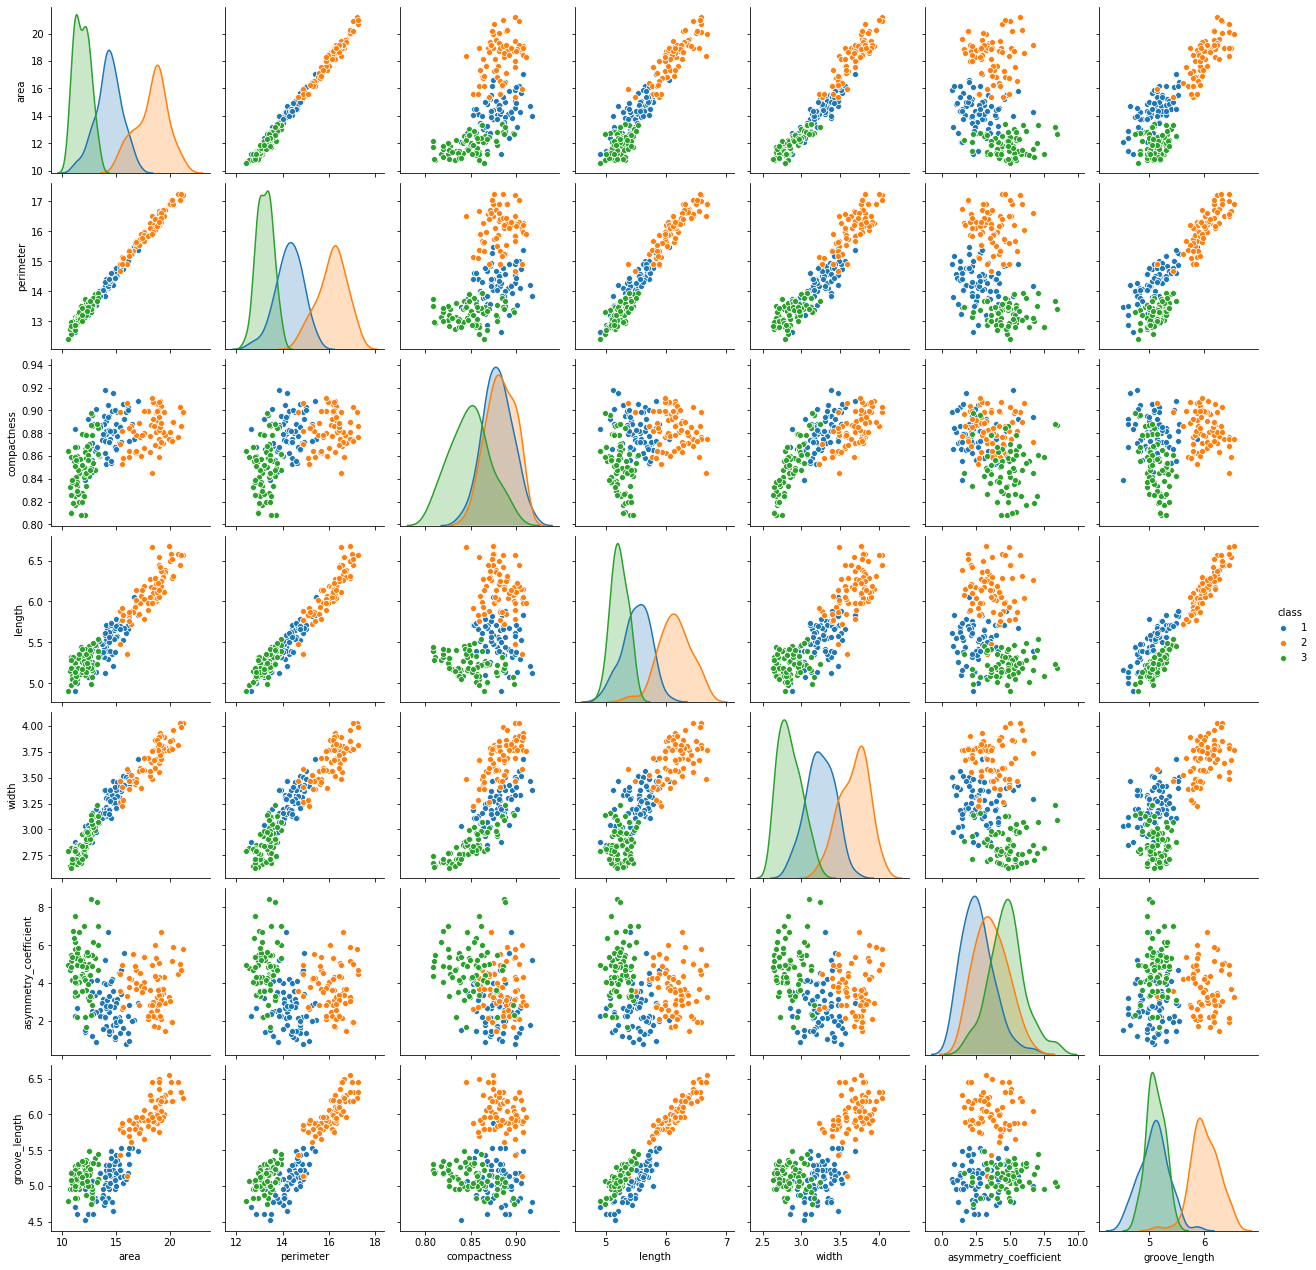

In [7]:
%%time
_ = sns.pairplot(seeds, hue='class')

## Bootstrapping

Now that we have a nice dataframe, it is time to deal with the size of the data. One method for this is bootstrapping.

In [292]:
#We split the data into a training set in order to keep some unseen data available for testing:
X = seeds.drop('class',axis=1)
y = seeds['class']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [293]:
#Now we create a training set dataframe with 80% of the entries evenly sampled from each class.
seeds_train = X_train
seeds_train['class'] = y_train
print(seeds_train)
seeds_train.sort_index(inplace=True)
seeds_train

      area  perimeter  compactness  length  width  asymmetry_coefficient  \
150  11.83      13.23       0.8496   5.263  2.840                  5.195   
96   19.31      16.59       0.8815   6.341  3.810                  3.477   
200  12.38      13.44       0.8609   5.219  2.989                  5.472   
68   14.37      14.39       0.8726   5.569  3.153                  1.464   
156  11.34      12.87       0.8596   5.053  2.849                  3.347   
..     ...        ...          ...     ...    ...                    ...   
106  18.85      16.17       0.9056   6.152  3.806                  2.843   
14   13.74      14.05       0.8744   5.482  3.114                  2.932   
92   18.81      16.29       0.8906   6.272  3.693                  3.237   
179  12.21      13.47       0.8453   5.357  2.893                  1.661   
102  19.46      16.50       0.8985   6.113  3.892                  4.308   

     groove_length  class  
150          5.307      3  
96           6.238      2  
200

C:\Users\Erik\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Erik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


area  perimeter  compactness  length  width  asymmetry_coefficient  \
0    15.26      14.84       0.8710   5.763  3.312                  2.221   
1    14.88      14.57       0.8811   5.554  3.333                  1.018   
2    14.29      14.09       0.9050   5.291  3.337                  2.699   
3    13.84      13.94       0.8955   5.324  3.379                  2.259   
4    16.14      14.99       0.9034   5.658  3.562                  1.355   
..     ...        ...          ...     ...    ...                    ...   
204  12.37      13.47       0.8567   5.204  2.960                  3.919   
205  12.19      13.20       0.8783   5.137  2.981                  3.631   
206  11.23      12.88       0.8511   5.140  2.795                  4.325   
208  11.84      13.21       0.8521   5.175  2.836                  3.598   
209  12.30      13.34       0.8684   5.243  2.974                  5.637   

     groove_length  class  
0            5.220      1  
1            4.956      1  
2            4.825      1  
3            4.805      1  
4            5.175      1  
..             ...    ...  
204          5.001      3  
205          4.870      3  
206          5.003      3  
208          5.044      3  
209          5.063      3  

[168 rows x 8 columns]

In [294]:
#We sample the training data with replacement 10000 times, creating a much larger sample size:
sampleDF = seeds_train.sample(10000, replace = True)
sampleDF.sort_values('class',inplace=True)
sampleDF.reset_index(inplace=True, drop=True)
print(sampleDF.head(),'\n',sampleDF.tail())

    area  perimeter  compactness  length  width  asymmetry_coefficient  \
0  14.69      14.49       0.8799   5.563  3.259                  3.586   
1  15.49      14.94       0.8724   5.757  3.371                  3.412   
2  14.86      14.67       0.8676   5.678  3.258                  2.129   
3  12.72      13.57       0.8686   5.226  3.049                  4.102   
4  15.69      14.75       0.9058   5.527  3.514                  1.599   

   groove_length  class  
0          5.219      1  
1          5.228      1  
2          5.351      1  
3          4.914      1  
4          5.046      1   
        area  perimeter  compactness  length  width  asymmetry_coefficient  \
9995  11.81      13.45       0.8198   5.413  2.716                  4.898   
9996  11.21      13.13       0.8167   5.279  2.687                  6.169   
9997  12.54      13.67       0.8425   5.451  2.879                  3.082   
9998  10.79      12.93       0.8107   5.317  2.648                  5.462   
9999  12.02 

In [295]:
#A result of the sampling is that the classes no longer have equal sample sizes:
for i in [1,2,3]:
    print(len(sampleDF[sampleDF['class']==i]),'class',i)

3556 class 1
3279 class 2
3165 class 3


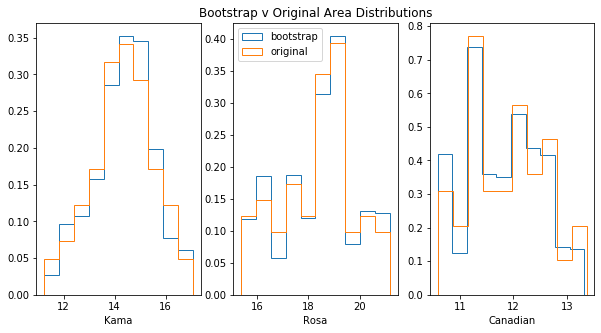

In [296]:
#The new sample is very close to the same distribution as the old sample:
new1=sampleDF[sampleDF['class']==1]
new2=sampleDF[sampleDF['class']==2]
new3=sampleDF[sampleDF['class']==3]
_=plt.figure(figsize=(10,5))
_=plt.subplot(1,3,1)
_=plt.hist(new1.area,histtype='step',density=True)
_=plt.hist(seeds_1.area,histtype='step',density=True)
_=plt.xlabel('Kama')
_=plt.subplot(1,3,2)
_=plt.title('Bootstrap v Original Area Distributions')
_=plt.hist(new2.area,histtype='step',density=True)
_=plt.hist(seeds_2.area,histtype='step',density=True)
_=plt.xlabel('Rosa')
_=plt.legend(['bootstrap','original'],loc='upper left')
_=plt.subplot(1,3,3)
_=plt.hist(new3.area,histtype='step',density=True)
_=plt.hist(seeds_3.area,histtype='step',density=True)
_=plt.xlabel('Canadian')

In [297]:
#One way to deal with the different sizes of class is to take many samples many times.
sample_list = [seeds_train.sample(1000,replace=True) for i in range(1000)]
lg_sample=pd.DataFrame()
for sample in sample_list:
    lg_sample = pd.concat([lg_sample,sample],ignore_index=True)

In [302]:
lg_sample.sort_values('class',inplace=True)
lg_sample.reset_index(drop=True,inplace=True)
lg_sample

area  perimeter  compactness  length  width  asymmetry_coefficient  \
0       14.29      14.09       0.9050   5.291  3.337                  2.699   
1       14.86      14.67       0.8676   5.678  3.258                  2.129   
2       13.54      13.85       0.8871   5.348  3.156                  2.587   
3       14.38      14.21       0.8951   5.386  3.312                  2.462   
4       13.16      13.55       0.9009   5.138  3.201                  2.461   
...       ...        ...          ...     ...    ...                    ...   
999995  12.21      13.47       0.8453   5.357  2.893                  1.661   
999996  10.80      12.57       0.8590   4.981  2.821                  4.773   
999997  11.14      12.79       0.8558   5.011  2.794                  6.388   
999998  11.14      12.79       0.8558   5.011  2.794                  6.388   
999999  12.80      13.47       0.8860   5.160  3.126                  4.873   

        groove_length  class  
0               4.825      1  
1               5.351      1  
2               5.178      1  
3               4.956      1  
4               4.783      1  
...               ...    ...  
999995          5.178      3  
999996          5.063      3  
999997          5.049      3  
999998          5.049      3  
999999          4.914      3  

[1000000 rows x 8 columns]

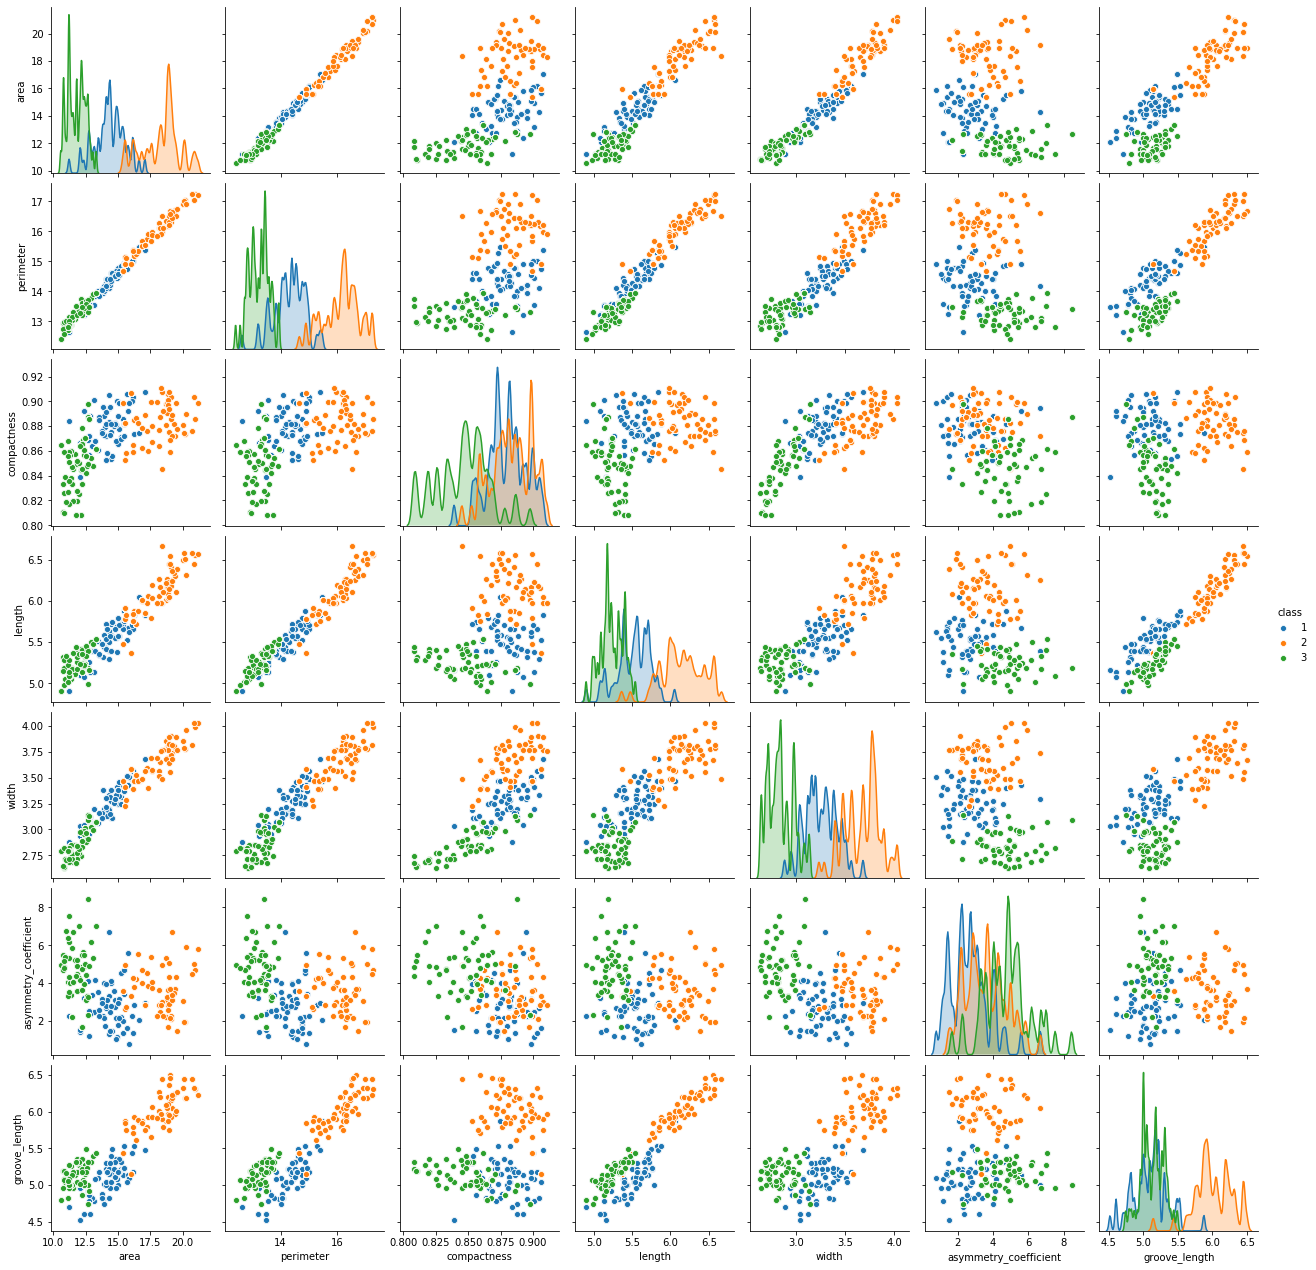

In [304]:
sns.pairplot(data=lg_sample,hue='class')

## Creating new data points
Looking at each individual parameter, we can find its distribution shape, mean, and standard deviation. These parameters will allow us to simulate the distribution and draw random samples. Many of the samples lie outside of the range of a linear fit. The sampled distribution data is then trimmed down by keeping only values for parameters that lied very close to the fit line.

In [328]:
#Create indices for each different class:
idx_1 = np.arange(70)
idx_2 = np.arange(70,140)
idx_3 = np.arange(140,210)
bs_idx_1 = np.random.choice(idx_1,len(idx_1))
bs_idx_2 = np.random.choice(idx_2,len(idx_2))
bs_idx_3 = np.random.choice(idx_3,len(idx_3))
seeds_1 = seeds_train[seeds_train['class']==1]
seeds_2 = seeds_train[seeds_train['class']==2]
seeds_3 = seeds_train[seeds_train['class']==3]
seeds_1.describe()

area  perimeter  compactness     length      width  \
count  59.000000  59.000000    59.000000  59.000000  59.000000   
mean   14.361864  14.310847     0.879849   5.518831   3.250576   
std     1.177497   0.559674     0.014918   0.221633   0.167295   
min    11.230000  12.630000     0.839200   4.902000   2.879000   
25%    13.760000  14.020000     0.871300   5.391500   3.139500   
50%    14.370000  14.390000     0.881100   5.545000   3.245000   
75%    15.080000  14.715000     0.889700   5.676000   3.377000   
max    17.080000  15.460000     0.907900   6.053000   3.683000   

       asymmetry_coefficient  groove_length  class  
count              59.000000      59.000000   59.0  
mean                2.709527       5.098169    1.0  
std                 1.142252       0.255650    0.0  
min                 0.765100       4.519000    1.0  
25%                 2.019500       4.956000    1.0  
50%                 2.688000       5.111000    1.0  
75%                 3.274000       5.223000    1.0  
max                 6.685000       5.877000    1.0

### Area

In [329]:
np.random.seed(np.random.randint(1,1000))

def ecdf(data):
    """Returns the the x and y required to plot a cdf form the given data. """
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return(x,y)

#### Class 1: Kama

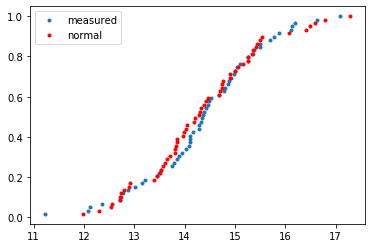

In [330]:
x_1,y_1 = ecdf(seeds_1.area)
x_norm,y_norm = ecdf(np.random.normal(seeds_1.area.mean(), seeds_1.area.std(),len(seeds_1)))
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(x_norm,y_norm,marker='.',linestyle='none', color = 'r')
_ = plt.legend(['measured','normal'])



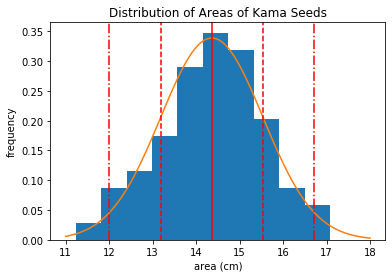

In [331]:
hist1 = np.histogram(seeds_1.area)
_ = plt.hist(seeds_1.area,density=True)
_ = plt.plot(np.linspace(11,18,100), norm.pdf(np.linspace(11,18,100), seeds_1.area.mean(), seeds_1.area.std()))
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of Areas of Kama Seeds')
_ = plt.axvline(seeds_1.area.mean(),color = 'r')
_ = plt.axvline(seeds_1.area.mean()+seeds_1.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_1.area.mean()-seeds_1.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_1.area.mean()+2*seeds_1.area.std(),color='r',linestyle='-.')
_ = plt.axvline(seeds_1.area.mean()-2*seeds_1.area.std(),color='r',linestyle='-.')

It appears that the Kama seed's areas are not quite normally distributed. We can derive the actual pdf using rv_histogram.

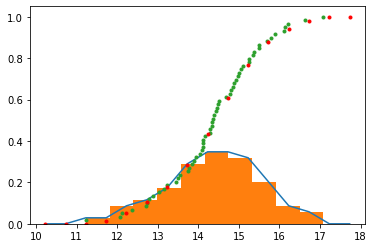

In [332]:
hist_dist = scipy.stats.rv_histogram(hist1)
X_1 = np.arange(seeds_1.area.min()-1,seeds_1.area.max()+1,.5)
Y_1 = hist_dist.cdf(X_1)
_ = plt.plot(X_1,hist_dist.pdf(X_1))
_ = plt.hist(seeds_1.area,density=True)
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(X_1,Y_1,marker='.',linestyle='none', color = 'r')

We can now use this matching pdf and cdf to ensure that the bootstrap data follows the same distribution for the Kama species.

The mean of the sample means is 14.36cm


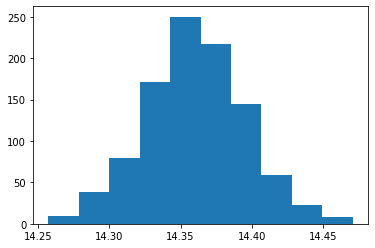

In [333]:
#Sample the data randomly 10,000 times, then take a thousand samples of 1,000 and compute the mean for each.
#Next compute the mean of the means and make a histogram showing the distribution of means.
bs_sample_1 = seeds_1.area.sample(n=10000,replace = True)
bs_sample_1_mean = [seeds_1.area.sample(n=1000,replace = True).mean() for i in range(1000)]
print('The mean of the sample means is '+str(round(np.mean(bs_sample_1_mean),2))+'cm')
_ = plt.hist(bs_sample_1_mean)

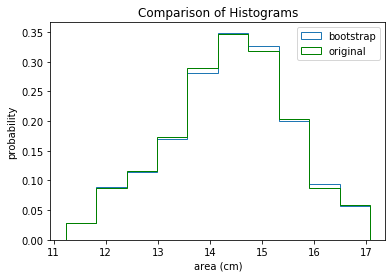

In [334]:
_ = plt.hist(bs_sample_1,histtype = 'step',density=True)
_ = plt.hist(seeds_1.area,histtype= 'step',density=True,color = 'g')
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('probability')
_ = plt.title('Comparison of Histograms')
_ = plt.legend(['bootstrap','original'])

We now have a bootstrapped sample of 10,000 points for the Kama area which is distributed approximately the same as the original data.

#### Class 2: Rosa

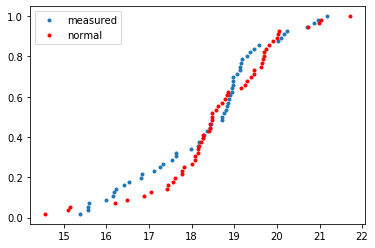

In [335]:
x_1,y_1 = ecdf(seeds_2.area)
x_norm,y_norm = ecdf(np.random.normal(seeds_2.area.mean(), seeds_2.area.std(),len(seeds_2)))
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(x_norm,y_norm,marker='.',linestyle='none', color = 'r')
_ = plt.legend(['measured','normal'])

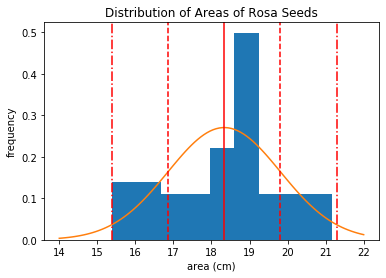

In [336]:
hist2 = np.histogram(seeds_2.area)
_ = plt.hist(seeds_2.area,bins=9,density=True)
_ = plt.plot(np.linspace(14,22,100), norm.pdf(np.linspace(14,22,100), seeds_2.area.mean(), seeds_2.area.std()))
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of Areas of Rosa Seeds')
_ = plt.axvline(seeds_2.area.mean(),color = 'r')
_ = plt.axvline(seeds_2.area.mean()+seeds_2.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_2.area.mean()-seeds_2.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_2.area.mean()+2*seeds_2.area.std(),color='r',linestyle='-.')
_ = plt.axvline(seeds_2.area.mean()-2*seeds_2.area.std(),color='r',linestyle='-.')

The Rosa wheat seed is not normally distributed.

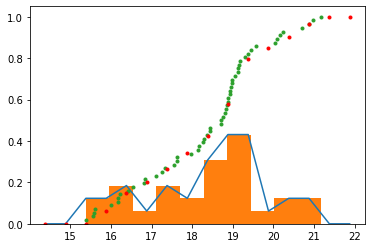

In [337]:
hist_dist_2 = scipy.stats.rv_histogram(hist2)
X_1 = np.arange(seeds_2.area.min()-1,seeds_2.area.max()+1,.5)
Y_1 = hist_dist_2.cdf(X_1)
_ = plt.plot(X_1,hist_dist_2.pdf(X_1))
_ = plt.hist(seeds_2.area,density=True)
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(X_1,Y_1,marker='.',linestyle='none', color = 'r')

The mean of the sample means is 18.33cm


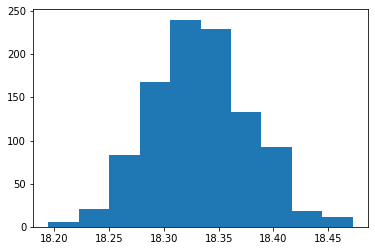

In [338]:
#Sample the data randomly 10,000 times, then take a thousand samples of 1,000 and compute the mean for each.
#Next compute the mean of the means and make a histogram showing the distribution of means.
bs_sample_2 = seeds_2.area.sample(n=10000,replace = True)
bs_sample_2_mean = [seeds_2.area.sample(n=1000,replace = True).mean() for i in range(1000)]
print('The mean of the sample means is '+str(round(np.mean(bs_sample_2_mean),2))+'cm')
_ = plt.hist(bs_sample_2_mean)

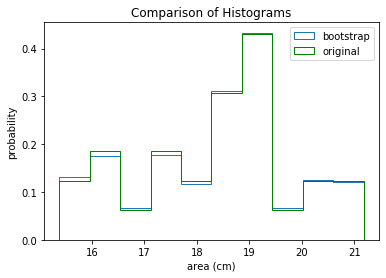

In [339]:
_ = plt.hist(bs_sample_2,histtype = 'step',density=True)
_ = plt.hist(seeds_2.area,histtype= 'step',density=True,color = 'g')
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('probability')
_ = plt.title('Comparison of Histograms')
_ = plt.legend(['bootstrap','original'])

#### Class 3: Canadian

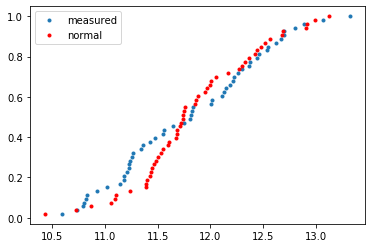

In [340]:
x_1,y_1 = ecdf(seeds_3.area)
x_norm,y_norm = ecdf(np.random.normal(seeds_3.area.mean(), seeds_3.area.std(),len(seeds_3)))
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(x_norm,y_norm,marker='.',linestyle='none', color = 'r')
_ = plt.legend(['measured','normal'])

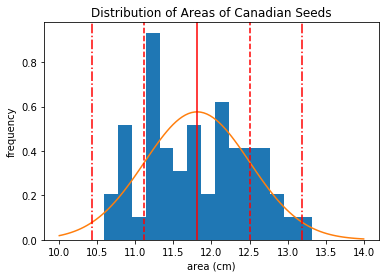

In [341]:
hist3 = np.histogram(seeds_3.area)
_ = plt.hist(seeds_3.area,bins=15,density=True)
_ = plt.plot(np.linspace(10,14,100), norm.pdf(np.linspace(10,14,100), seeds_3.area.mean(), seeds_3.area.std()))
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('frequency')
_ = plt.title('Distribution of Areas of Canadian Seeds')
_ = plt.axvline(seeds_3.area.mean(),color = 'r')
_ = plt.axvline(seeds_3.area.mean()+seeds_3.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_3.area.mean()-seeds_3.area.std(),color='r',linestyle='--')
_ = plt.axvline(seeds_3.area.mean()+2*seeds_3.area.std(),color='r',linestyle='-.')
_ = plt.axvline(seeds_3.area.mean()-2*seeds_3.area.std(),color='r',linestyle='-.')

The upper half of the Canadian seed area distribution is closer to being normally distributed than the lower half. It almost appears to be bi-modal.

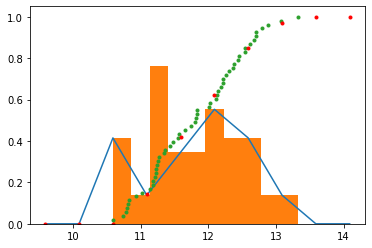

In [342]:
hist_dist_3 = scipy.stats.rv_histogram(hist3)
X_1 = np.arange(seeds_3.area.min()-1,seeds_3.area.max()+1,.5)
Y_1 = hist_dist_3.cdf(X_1)
_ = plt.plot(X_1,hist_dist_3.pdf(X_1))
_ = plt.hist(seeds_3.area,density=True)
_ = plt.plot(x_1,y_1,marker = '.',linestyle='none')
_ = plt.plot(X_1,Y_1,marker='.',linestyle='none', color = 'r')

The mean of the sample means is 11.81cm


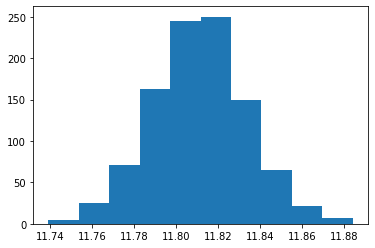

In [343]:
bs_sample_3 = seeds_3.area.sample(n=10000,replace = True)
bs_sample_3_mean = [seeds_3.area.sample(n=1000,replace = True).mean() for i in range(1000)]
print('The mean of the sample means is '+str(round(np.mean(bs_sample_3_mean),2))+'cm')
_ = plt.hist(bs_sample_3_mean)

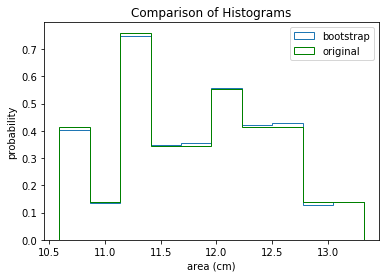

In [344]:
_ = plt.hist(bs_sample_3,histtype = 'step',density=True)
_ = plt.hist(seeds_3.area,histtype= 'step',density=True,color = 'g')
_ = plt.xlabel('area (cm)')
_ = plt.ylabel('probability')
_ = plt.title('Comparison of Histograms')
_ = plt.legend(['bootstrap','original'])

In [345]:
#We now create a dataframe with 30,000 entries for area, with 10,000 entries for each species:
seeds_area_master = pd.DataFrame(pd.concat([bs_sample_1,bs_sample_2,bs_sample_3]))
print('New area data:\n',seeds_area_master.describe(),'\n\nOld area data:\n',seeds.area.describe())

New area data:
                area
count  30000.000000
mean      14.842746
std        2.917022
min       10.590000
25%       12.260000
50%       14.370000
75%       17.275000
max       21.180000 

Old area data:
 count    210.000000
mean      14.847524
std        2.909699
min       10.590000
25%       12.270000
50%       14.355000
75%       17.305000
max       21.180000
Name: area, dtype: float64


Next we apply the same process to the rest of the columns in seeds_train.

In [346]:
def seedSampler(data):
    return(data.sample(n=10000,replace = True))

df=pd.DataFrame()
for name in seeds.columns:
    df_temp=pd.DataFrame()
    df_temp[str(name)] = seedSampler(seeds_1[str(name)])
    df_temp.reset_index(drop=True,inplace=True)
    df[str(name)]=df_temp[str(name)]



In [347]:
df

area  perimeter  compactness  length  width  asymmetry_coefficient  \
0     14.16      14.10       0.8726   5.658  3.371                  2.249   
1     14.86      15.38       0.8716   5.570  3.168                  2.587   
2     15.26      14.57       0.8744   5.658  3.462                  1.415   
3     14.11      14.26       0.9079   5.678  3.158                  1.599   
4     13.22      13.85       0.8823   5.714  3.201                  3.373   
...     ...        ...          ...     ...    ...                    ...   
9995  12.88      14.76       0.9034   5.527  3.114                  2.932   
9996  15.50      14.91       0.8944   5.541  3.288                  3.112   
9997  15.50      13.19       0.8726   5.763  3.396                  1.502   
9998  12.74      14.40       0.8676   5.520  3.113                  3.328   
9999  13.50      13.94       0.8722   4.902  3.683                  2.462   

      groove_length  class  
0             5.132      1  
1             5.001      1  
2             4.869      1  
3             5.487      1  
4             4.703      1  
...             ...    ...  
9995          5.178      1  
9996          5.144      1  
9997          5.038      1  
9998          4.782      1  
9999          5.111      1  

[10000 rows x 8 columns]

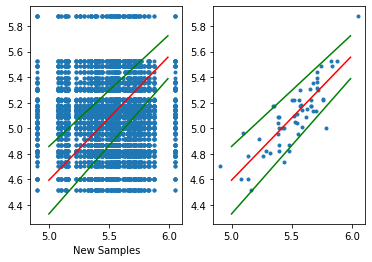

In [348]:
m,b = np.polyfit(seeds_1.length,seeds_1.groove_length,1)
plt.figure()
plt.subplot(1,2,1)
plt.plot(df.length,df.groove_length,marker='.',linestyle='none')
plt.plot(np.arange(5,6,.01),m*np.arange(5,6,.01)+b,color='r')
plt.plot(np.arange(5,6,.01),.9*m*np.arange(5,6,.01)+b+.75,color='g')
plt.plot(np.arange(5,6,.01),1.1*m*np.arange(5,6,.01)+b-.75,color='g')
plt.xlabel('New Samples')
plt.subplot(1,2,2)
plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none')
plt.plot(np.arange(5,6,.01),.9*m*np.arange(5,6,.01)+b+.75,color='g')
plt.plot(np.arange(5,6,.01),1.1*m*np.arange(5,6,.01)+b-.75,color='g')
plt.plot(np.arange(5,6,.01),m*np.arange(5,6,.01)+b,color='r')

In [349]:
%%time
DF = pd.DataFrame(columns=columns)
#upper = .9*m*np.arange(5,6,.01)+b+.75
#lower = 1.1*m*np.arange(5,6,.01)+b-.75
for i in range(len(df)):
    if df.iloc[i,6] < .9*m*df.iloc[i,3]+b+.75 and df.iloc[i,6] > m*df.iloc[i,3]+b:
        DF = DF.append(df.iloc[i],ignore_index=True)
    if df.iloc[i,6] > 1.1*m*df.iloc[i,3]+b-.75 and df.iloc[i,6] < m*df.iloc[i,3]+b:
        DF = DF.append(df.iloc[i],ignore_index=True)

Wall time: 25.9 s


In [350]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4877 entries, 0 to 4876
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area                   4877 non-null   float64
 1   perimeter              4877 non-null   float64
 2   compactness            4877 non-null   float64
 3   length                 4877 non-null   float64
 4   width                  4877 non-null   float64
 5   asymmetry_coefficient  4877 non-null   float64
 6   groove_length          4877 non-null   float64
 7   class                  4877 non-null   float64
dtypes: float64(8)
memory usage: 304.9 KB


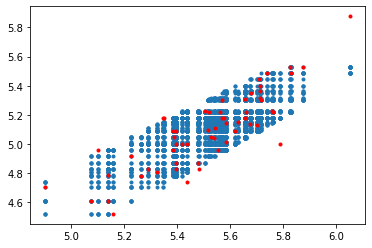

In [352]:
_=plt.plot(DF.length,DF.groove_length,marker='.',linestyle='none')
_=plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color='r')

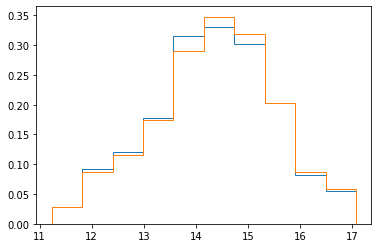

In [353]:
_ = plt.hist(DF.area,histtype='step',density = True)
_ = plt.hist(seeds_1.area,histtype='step',density=True)

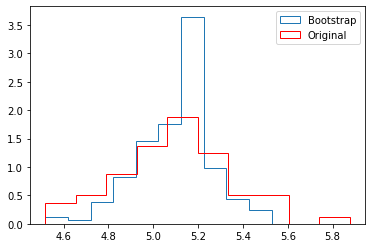

In [354]:
_ = plt.hist(DF.groove_length,histtype='step',density=True)
_ = plt.hist(seeds_1.groove_length,histtype='step',density=True,color='red')
_ = plt.legend(['Bootstrap','Original'])

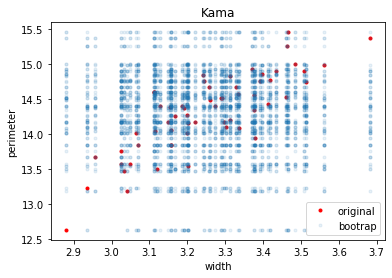

In [356]:
_ = plt.plot(seeds_1.width,seeds_1.perimeter,marker='.',linestyle='none', color='r')
_ = plt.plot(DF.width, DF.perimeter,marker = '.',linestyle='none',alpha=.1)
_ = plt.legend(['original','bootrap'])
_ = plt.xlabel('width')
_ = plt.ylabel('perimeter')
_ = plt.title('Kama')

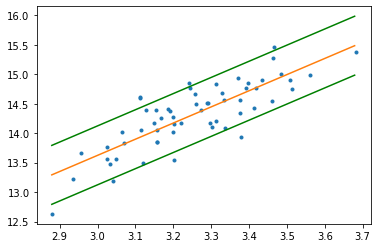

In [357]:
m,b = np.polyfit(seeds_1.width,seeds_1.perimeter,1)
X = np.arange(seeds_1.width.min(), seeds_1.width.max(),.01)
_ = plt.plot(seeds_1.width,seeds_1.perimeter,marker='.',linestyle='none')
_ = plt.plot(X,m*X+b)
_ = plt.plot(X,m*X+b+.5,color='g')
_ = plt.plot(X,m*X+b-.5,color='g')


In [358]:
%%time
DF2 = pd.DataFrame(columns=columns)
for i in range(len(DF)):
    if DF.iloc[i,1] < m*DF.iloc[i,4]+b+.5 and DF.iloc[i,1] > m*DF.iloc[i,4]+b:
        DF2 = DF2.append(DF.iloc[i],ignore_index=True)
    if DF.iloc[i,1] > m*DF.iloc[i,4]+b-.5 and DF.iloc[i,1] < m*DF.iloc[i,4]+b:
        DF2 = DF2.append(DF.iloc[i],ignore_index=True)

Wall time: 16 s


In [359]:
DF2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area                   2513 non-null   float64
 1   perimeter              2513 non-null   float64
 2   compactness            2513 non-null   float64
 3   length                 2513 non-null   float64
 4   width                  2513 non-null   float64
 5   asymmetry_coefficient  2513 non-null   float64
 6   groove_length          2513 non-null   float64
 7   class                  2513 non-null   float64
dtypes: float64(8)
memory usage: 157.2 KB


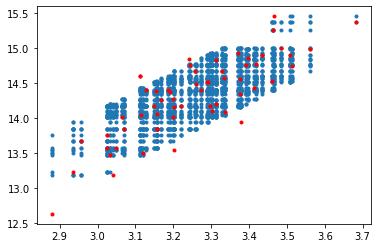

In [360]:
_ = plt.plot(DF2.width,DF2.perimeter,marker='.',linestyle='none')
_ = plt.plot(seeds_1.width,seeds_1.perimeter,marker='.',linestyle='none',color ='r')

Wall time: 24.3 s


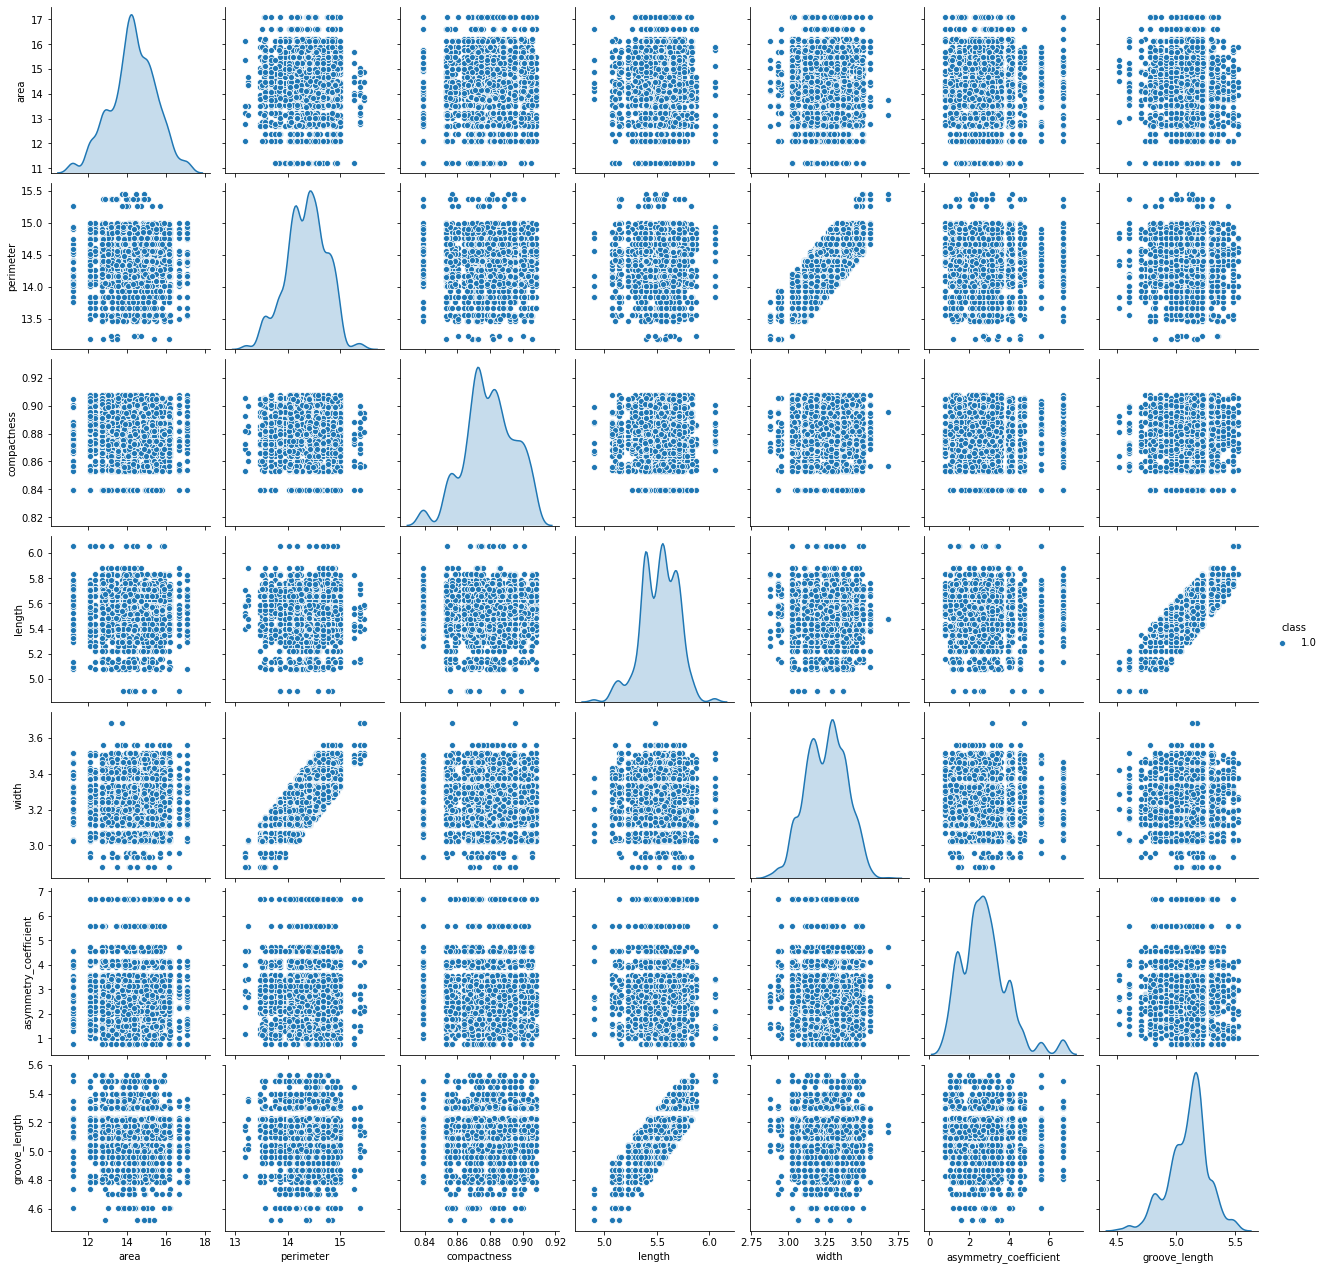

In [363]:
%%time
_ = sns.pairplot(DF2, hue='class')

In [423]:
def dfTrimmer1D(df,to_fit,xcol,ycol,names,rng=.1):
    m,b=np.polyfit(to_fit.iloc[:,xcol],to_fit.iloc[:,ycol],1)
    X = np.arange(to_fit.iloc[:,xcol].min(),to_fit.iloc[:,xcol].max(),.05)
    _=plt.plot(to_fit.iloc[:,xcol],to_fit.iloc[:,ycol],marker='.',linestyle='none')
    _=plt.plot(X,m*X+b)
    _=plt.plot(X,m*X+b+rng,color = 'g')
    _=plt.plot(X,m*X+b-rng,color = 'g')
    plt.show()
    temp = pd.DataFrame(columns=names)
    for i in range(len(df)):
        if df.iloc[i,ycol] < m*df.iloc[i,xcol]+b+rng and df.iloc[i,ycol] > m*df.iloc[i,xcol]+b:
            temp = temp.append(df.iloc[i],ignore_index=True)
        if df.iloc[i,ycol] > m*df.iloc[i,xcol]+b-rng and df.iloc[i,ycol] < m*df.iloc[i,xcol]+b:
            temp = temp.append(df.iloc[i],ignore_index=True)

    return(temp)

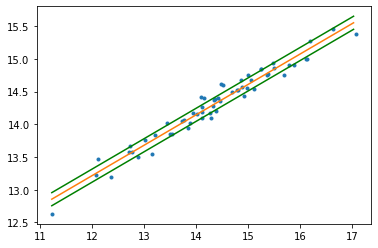

area  perimeter  compactness  length  width  asymmetry_coefficient  \
0   14.88      14.57       0.8811   5.554  3.333                  1.018   
1   16.14      14.99       0.9034   5.658  3.562                  1.355   
2   14.38      14.21       0.8951   5.386  3.312                  2.462   
3   14.69      14.49       0.8799   5.563  3.259                  3.586   
4   14.11      14.10       0.8911   5.420  3.302                  2.700   
5   16.63      15.46       0.8747   6.053  3.465                  2.040   
6   14.03      14.16       0.8796   5.438  3.201                  1.717   
7   13.89      14.02       0.8880   5.439  3.199                  3.986   
8   13.78      14.06       0.8759   5.479  3.156                  3.136   
9   13.74      14.05       0.8744   5.482  3.114                  2.932   
10  15.69      14.75       0.9058   5.527  3.514                  1.599   
11  12.72      13.57       0.8686   5.226  3.049                  4.102   
12  14.11      14.26       0.8722   5.520  3.168                  2.688   
13  12.08      13.23       0.8664   5.099  2.936                  1.415   
14  15.01      14.76       0.8657   5.789  3.245                  1.791   
15  13.02      13.76       0.8641   5.395  3.026                  3.373   
16  12.74      13.67       0.8564   5.395  2.956                  2.504   
17  14.11      14.18       0.8820   5.541  3.221                  2.754   
18  13.45      14.02       0.8604   5.516  3.065                  3.531   
19  14.09      14.41       0.8529   5.717  3.186                  3.920   
20  13.94      14.17       0.8728   5.585  3.150                  2.124   
21  15.05      14.68       0.8779   5.712  3.328                  2.129   
22  16.12      15.00       0.9000   5.709  3.485                  2.270   
23  16.20      15.27       0.8734   5.826  3.464                  2.823   
24  17.08      15.38       0.9079   5.832  3.683                  2.956   
25  14.80      14.52       0.8823   5.656  3.288                  3.112   
26  13.54      13.85       0.8871   5.348  3.156                  2.587   
27  13.50      13.85       0.8852   5.351  3.158                  2.249   
28  15.50      14.86       0.8820   5.877  3.396                  4.711   
29  15.11      14.54       0.8986   5.579  3.462                  3.128   
30  15.36      14.76       0.8861   5.701  3.393                  1.367   
31  14.99      14.56       0.8883   5.570  3.377                  2.958   
32  14.79      14.52       0.8819   5.545  3.291                  2.704   
33  14.43      14.40       0.8751   5.585  3.272                  3.975   
34  15.78      14.91       0.8923   5.674  3.434                  5.593   
35  14.33      14.28       0.8831   5.504  3.199                  3.328   
36  14.46      14.35       0.8818   5.388  3.377                  2.802   
37  14.92      14.43       0.9006   5.384  3.412                  1.142   
38  15.38      14.77       0.8857   5.662  3.419                  1.999   
39  12.11      13.47       0.8392   5.159  3.032                  1.502   
40  13.22      13.84       0.8680   5.395  3.070                  4.157   
41  12.78      13.57       0.8716   5.262  3.026                  1.176   
42  14.34      14.37       0.8726   5.630  3.190                  1.313   
43  14.37      14.39       0.8726   5.569  3.153                  1.464   

    groove_length  class  
0           4.956    1.0  
1           5.175    1.0  
2           4.956    1.0  
3           5.219    1.0  
4           5.000    1.0  
5           5.877    1.0  
6           5.001    1.0  
7           4.738    1.0  
8           4.872    1.0  
9           4.825    1.0  
10          5.046    1.0  
11          4.914    1.0  
12          5.219    1.0  
13          4.961    1.0  
14          5.001    1.0  
15          4.825    1.0  
16          4.869    1.0  
17          5.038    1.0  
18          5.097    1.0  
19          5.299    1.0  
20          5.012    1.0  
21          5.360    1.0  
22      

In [404]:
dfTrimmer1D(seeds_1,0,1,names=columns)

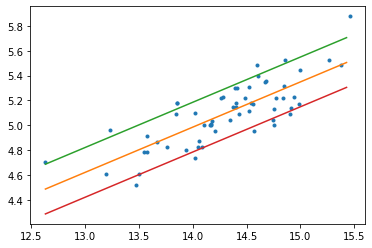

In [369]:
m,b = np.polyfit(seeds_1.perimeter,seeds_1.groove_length,1)
X = np.arange(seeds_1.perimeter.min(),seeds_1.perimeter.max(),.05)
_=plt.plot(seeds_1.perimeter,seeds_1.groove_length,marker='.',linestyle='none')
_=plt.plot(X,m*X+b)
_=plt.plot(X,m*X+b+.2)
_=plt.plot(X,m*X+b-.2)
DF3 = pd.DataFrame(columns=columns)
for i in range(len(DF2)):
    if DF2.iloc[i,6] < m*DF2.iloc[i,1]+b+.2 and DF2.iloc[i,6] > m*DF2.iloc[i,1]+b:
        DF3 = DF3.append(DF2.iloc[i],ignore_index=True)
    if DF2.iloc[i,6] > m*DF2.iloc[i,1]+b-.2 and DF2.iloc[i,6] < m*DF2.iloc[i,1]+b:
        DF3 = DF3.append(DF2.iloc[i],ignore_index=True)

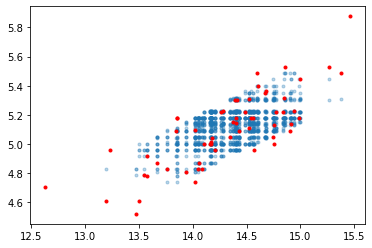

In [384]:
_ = plt.plot(DF3.perimeter,DF3.groove_length,marker='.',linestyle='none',alpha=.3)
_ = plt.plot(seeds_1.perimeter,seeds_1.groove_length,marker='.',linestyle='none',color='r')

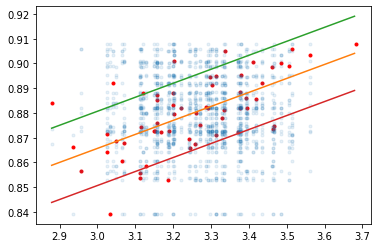

In [371]:
m,b = np.polyfit(seeds_1.width,seeds_1.compactness,1)
X = np.arange(seeds_1.width.min(),seeds_1.width.max(),.05)
_=plt.plot(seeds_1.width,seeds_1.compactness,marker='.',linestyle='none', color='r')
_=plt.plot(DF3.width,DF3.compactness,marker='.',linestyle='none',alpha=.1)
_=plt.plot(X,m*X+b)
_=plt.plot(X,m*X+b+.015)
_=plt.plot(X,m*X+b-.015)
DF4 = pd.DataFrame(columns=columns)
for i in range(len(DF3)):
    if DF3.iloc[i,2] < m*DF3.iloc[i,4]+b+.015 and DF3.iloc[i,2] > m*DF3.iloc[i,4]+b:
        DF4 = DF4.append(DF3.iloc[i],ignore_index=True)
    if DF3.iloc[i,2] > m*DF3.iloc[i,4]+b-.015 and DF3.iloc[i,2] < m*DF3.iloc[i,4]+b:
        DF4 = DF4.append(DF3.iloc[i],ignore_index=True)

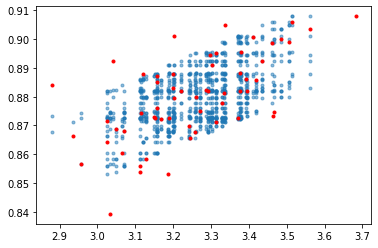

In [372]:
_ = plt.plot(DF4.width,DF4.compactness,marker='.',linestyle='none',alpha=.5)
_ = plt.plot(seeds_1.width,seeds_1.compactness,marker='.',linestyle='none',color='red')

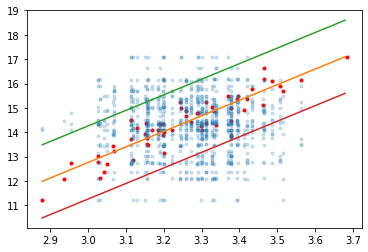

In [375]:
m,b = np.polyfit(seeds_1.width,seeds_1.area,1)
X = np.arange(seeds_1.width.min(),seeds_1.width.max(),.05)
_=plt.plot(seeds_1.width,seeds_1.area,marker='.',linestyle='none',color='r')
_=plt.plot(DF4.width,DF4.area,marker='.',linestyle='none',alpha=.2)
_=plt.plot(X,m*X+b)
_=plt.plot(X,m*X+b+1.5)
_=plt.plot(X,m*X+b-1.5)
DF5 = pd.DataFrame(columns=columns)
for i in range(len(DF4)):
    if DF4.iloc[i,0] < m*DF4.iloc[i,4]+b+1.5 and DF4.iloc[i,0] > m*DF4.iloc[i,4]+b:
        DF5 = DF5.append(DF4.iloc[i],ignore_index=True)
    if DF4.iloc[i,0] > m*DF4.iloc[i,4]+b-1.5 and DF4.iloc[i,0] < m*DF4.iloc[i,4]+b:
        DF5 = DF5.append(DF4.iloc[i],ignore_index=True)

In [376]:
DF5

area  perimeter  compactness  length  width  asymmetry_coefficient  \
0    16.12      14.94       0.8988   5.420  3.465                  2.270   
1    15.38      14.60       0.8923   5.701  3.377                  1.367   
2    13.22      14.39       0.8726   5.438  3.153                  2.124   
3    15.36      14.52       0.8779   5.789  3.288                  3.136   
4    15.78      14.41       0.8747   5.262  3.272                  3.328   
..     ...        ...          ...     ...    ...                    ...   
737  13.45      14.35       0.8796   5.714  3.242                  5.593   
738  14.99      14.40       0.8840   5.585  3.337                  1.355   
739  14.86      14.56       0.8686   5.395  3.291                  6.685   
740  15.26      14.17       0.8861   5.569  3.291                  4.116   
741  15.50      14.91       0.8944   5.541  3.288                  3.112   

     groove_length  class  
0            5.132    1.0  
1            5.314    1.0  
2            5.132    1.0  
3            5.299    1.0  
4            4.961    1.0  
..             ...    ...  
737          5.219    1.0  
738          5.088    1.0  
739          5.001    1.0  
740          5.175    1.0  
741          5.144    1.0  

[742 rows x 8 columns]

Wall time: 25.2 s


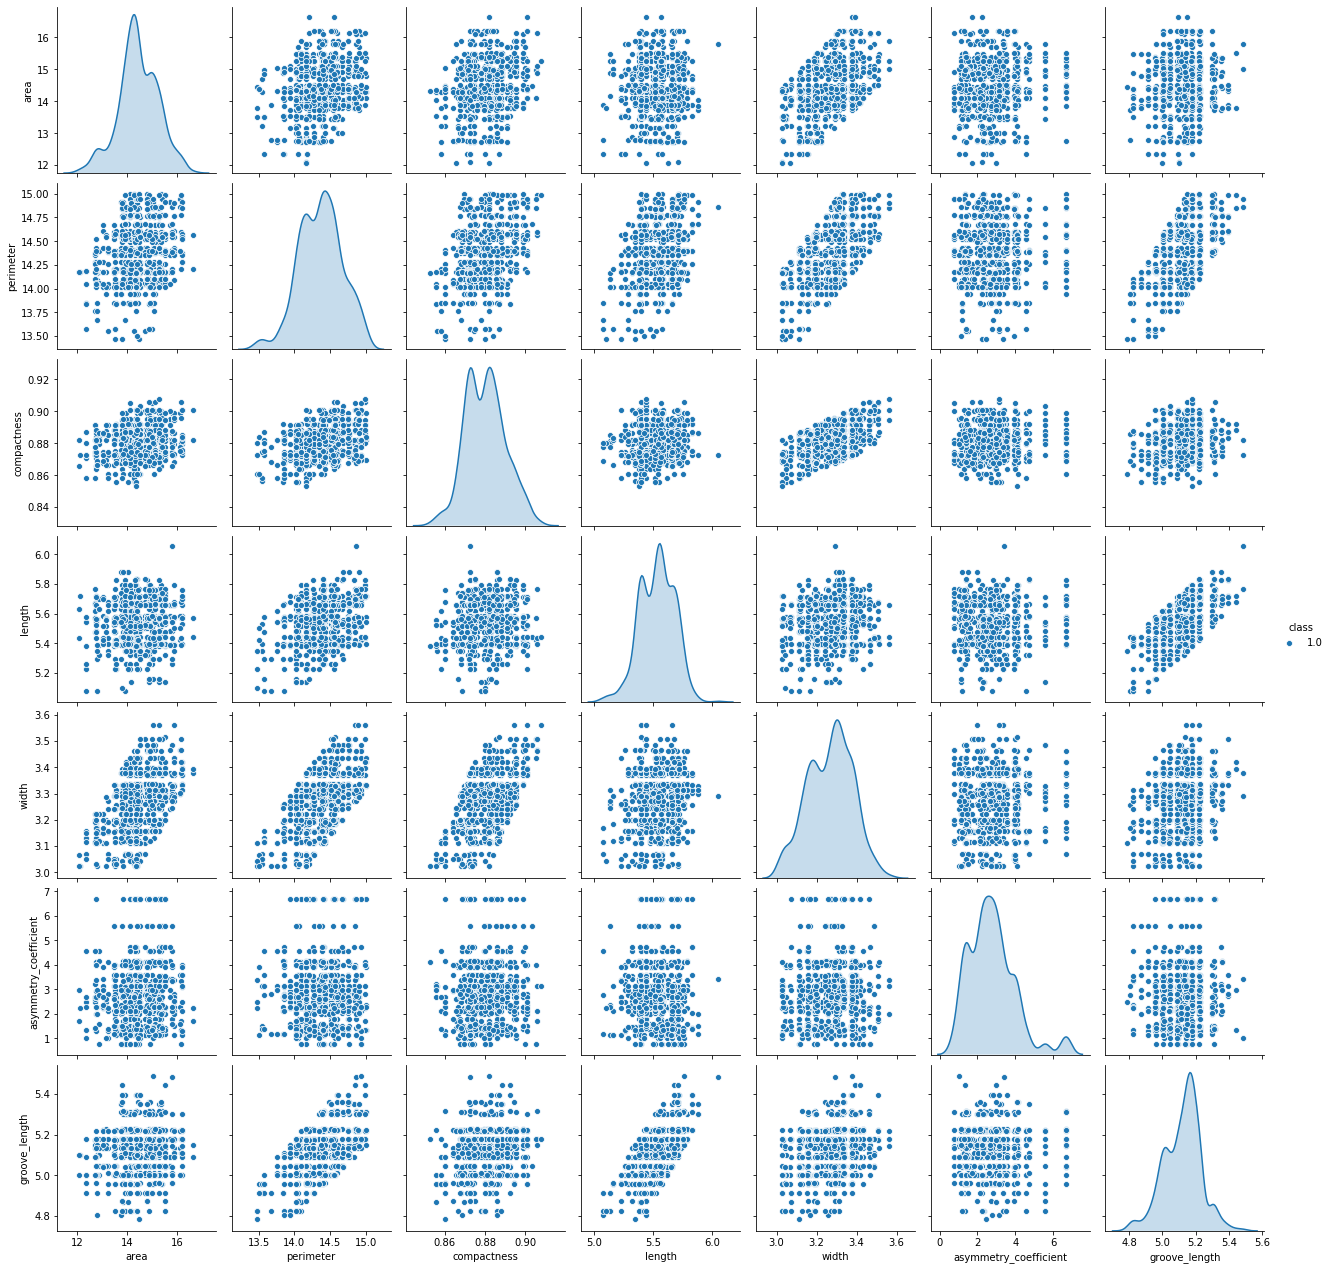

In [377]:
%%time
sns.pairplot(DF5,hue='class')

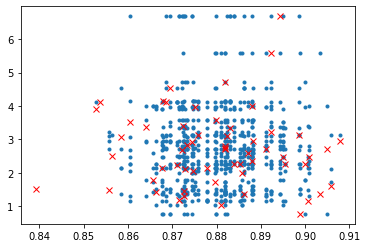

In [378]:
_ = plt.plot(DF5.compactness,DF5.asymmetry_coefficient,marker='.',linestyle='none')
_ = plt.plot(seeds_1.compactness,seeds_1.asymmetry_coefficient,marker='x',linestyle='none',color='r')

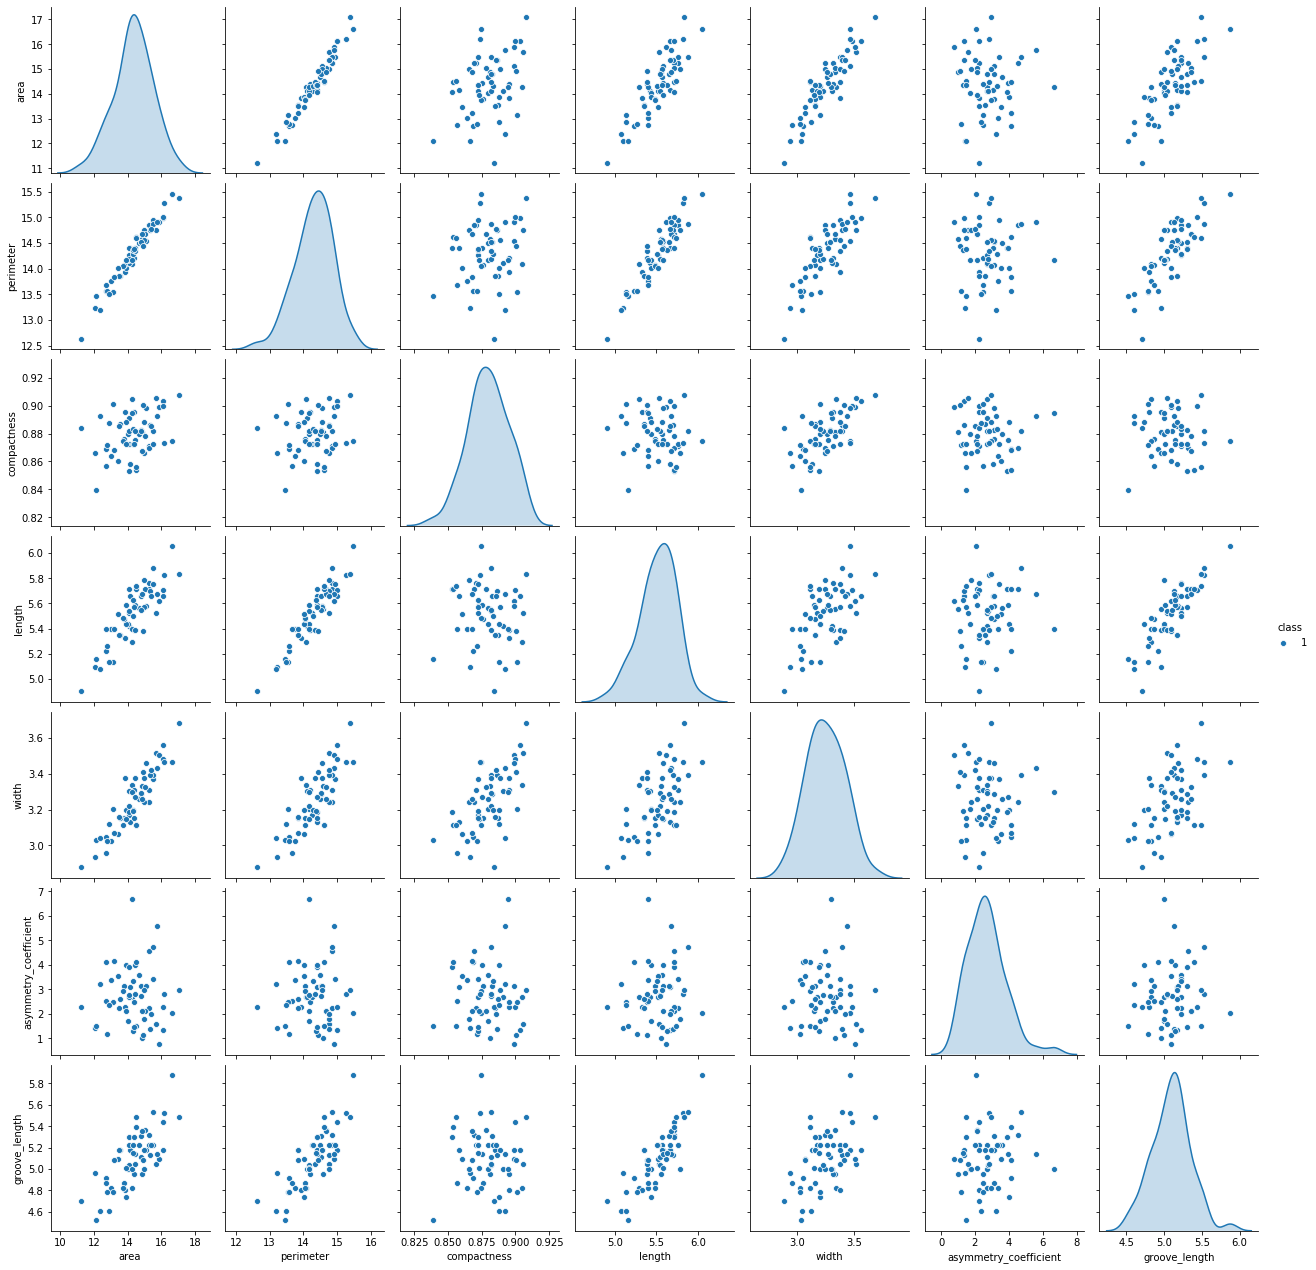

In [379]:
sns.pairplot(seeds_1,hue='class')

In [380]:
len(DF5)

742

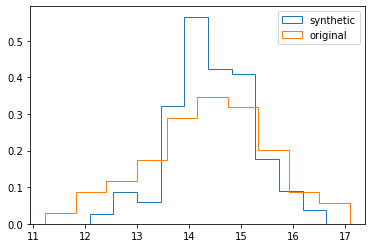

In [440]:
plt.hist(DF5.area,histtype='step',density=True)
plt.hist(seeds_1.area,histtype='step',density=True)
plt.legend(['synthetic','original'])

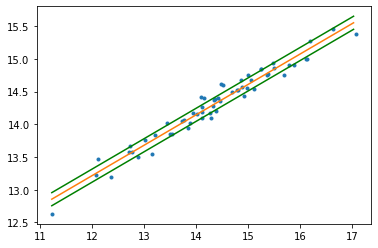

In [424]:
DF6 = dfTrimmer1D(df=DF5,to_fit=seeds_1,xcol=0,ycol=1,names=columns)

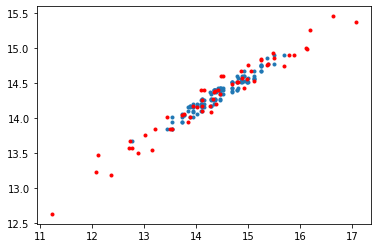

In [425]:
_=plt.plot(DF6.area,DF6.perimeter,marker='.',linestyle='none')
_=plt.plot(seeds_1.area,seeds_1.perimeter,marker='.',linestyle='none',color='r')

In [435]:
DF_Master = pd.concat([seeds_1,DF6],ignore_index=True)
DF_Master

area  perimeter  compactness  length  width  asymmetry_coefficient  \
0    15.26      14.84       0.8710   5.763  3.312                  2.221   
1    14.88      14.57       0.8811   5.554  3.333                  1.018   
2    14.29      14.09       0.9050   5.291  3.337                  2.699   
3    13.84      13.94       0.8955   5.324  3.379                  2.259   
4    16.14      14.99       0.9034   5.658  3.562                  1.355   
..     ...        ...          ...     ...    ...                    ...   
180  14.99      14.52       0.8716   5.757  3.258                  2.956   
181  13.54      14.02       0.8676   5.395  3.291                  1.717   
182  14.16      14.26       0.8747   5.674  3.333                  3.112   
183  14.86      14.56       0.8686   5.395  3.291                  6.685   
184  15.50      14.91       0.8944   5.541  3.288                  3.112   

     groove_length  class  
0            5.220    1.0  
1            4.956    1.0  
2            4.825    1.0  
3            4.805    1.0  
4            5.175    1.0  
..             ...    ...  
180          5.175    1.0  
181          5.012    1.0  
182          5.132    1.0  
183          5.001    1.0  
184          5.144    1.0  

[185 rows x 8 columns]

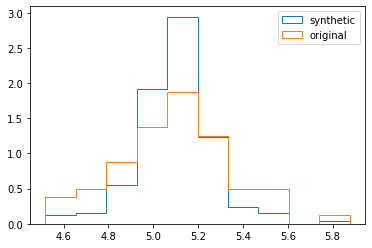

In [437]:
_=plt.hist(DF_Master.groove_length,histtype='step',density=True)
_=plt.hist(seeds_1.groove_length,histtype='step',density=True)
_=plt.legend(['synthetic','original'])

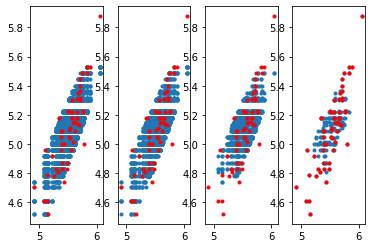

In [438]:
_ = plt.subplot(1,4,1)
_ = plt.plot(DF.length,DF.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')
_ = plt.subplot(1,4,2)
_ = plt.plot(DF2.length,DF2.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')
_ = plt.subplot(1,4,3)
_ = plt.plot(DF3.length,DF3.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')
_ = plt.subplot(1,4,4)
_ = plt.plot(DF_Master.length,DF_Master.groove_length,marker='.',linestyle='none')
_ = plt.plot(seeds_1.length,seeds_1.groove_length,marker='.',linestyle='none',color ='r')

Wall time: 28.9 s


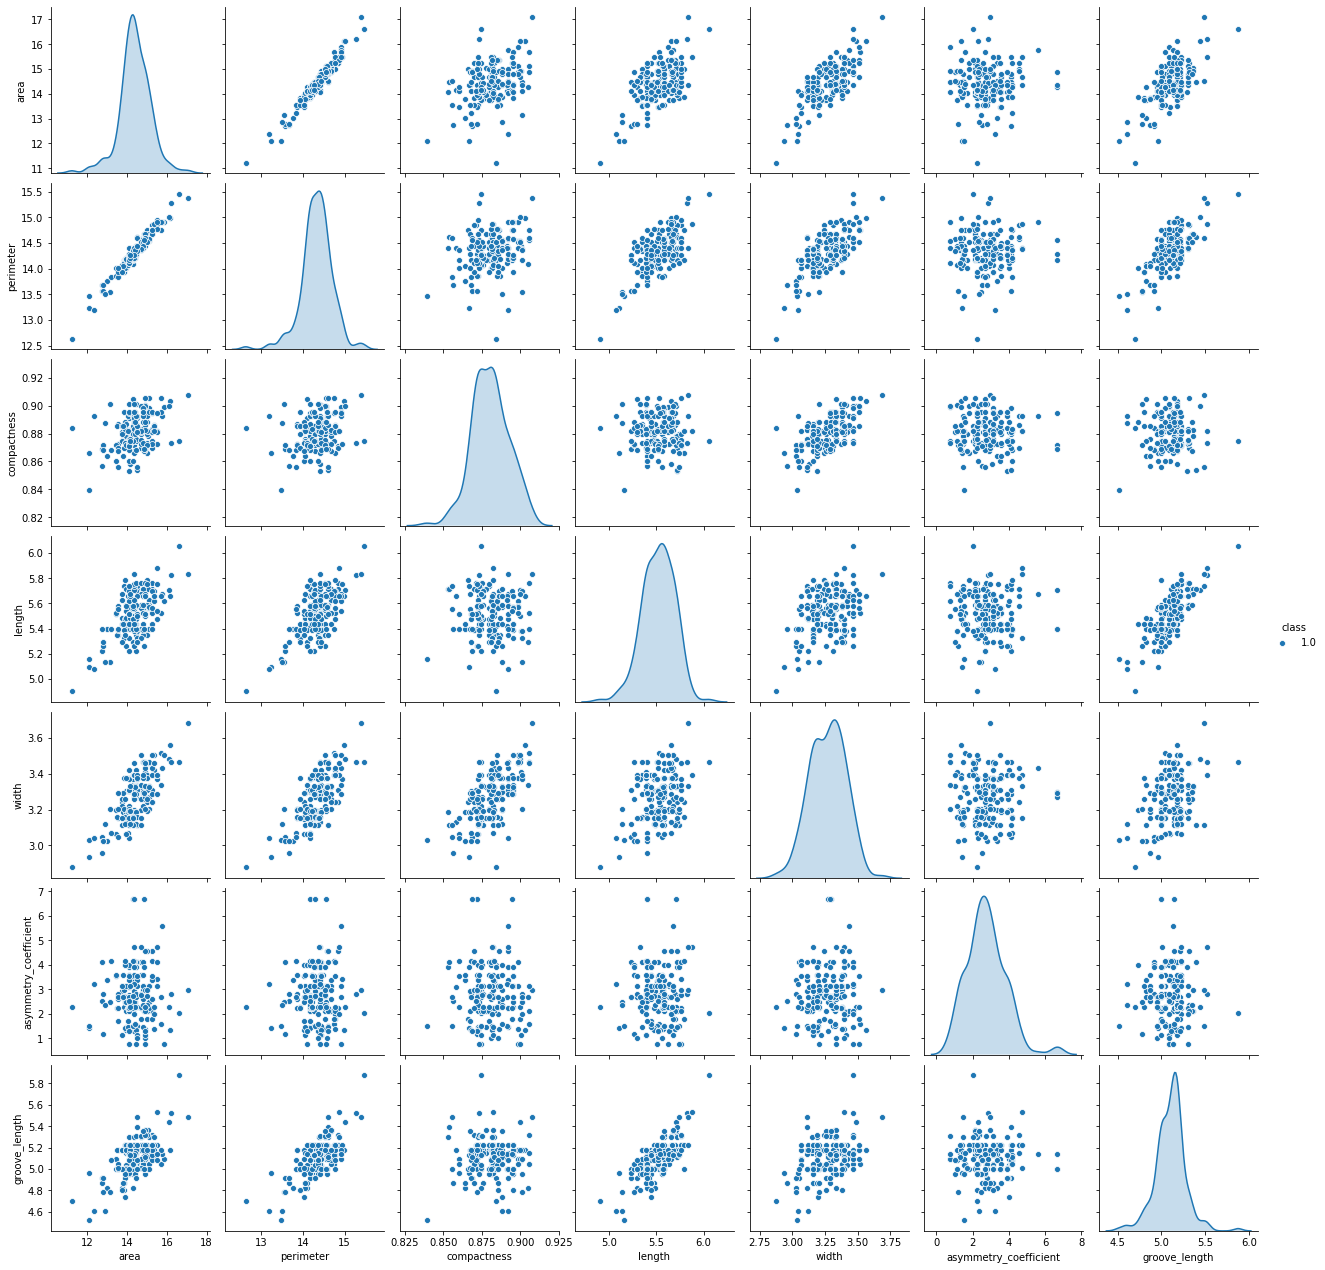

In [439]:
%%time
sns.pairplot(DF_Master,hue='class')

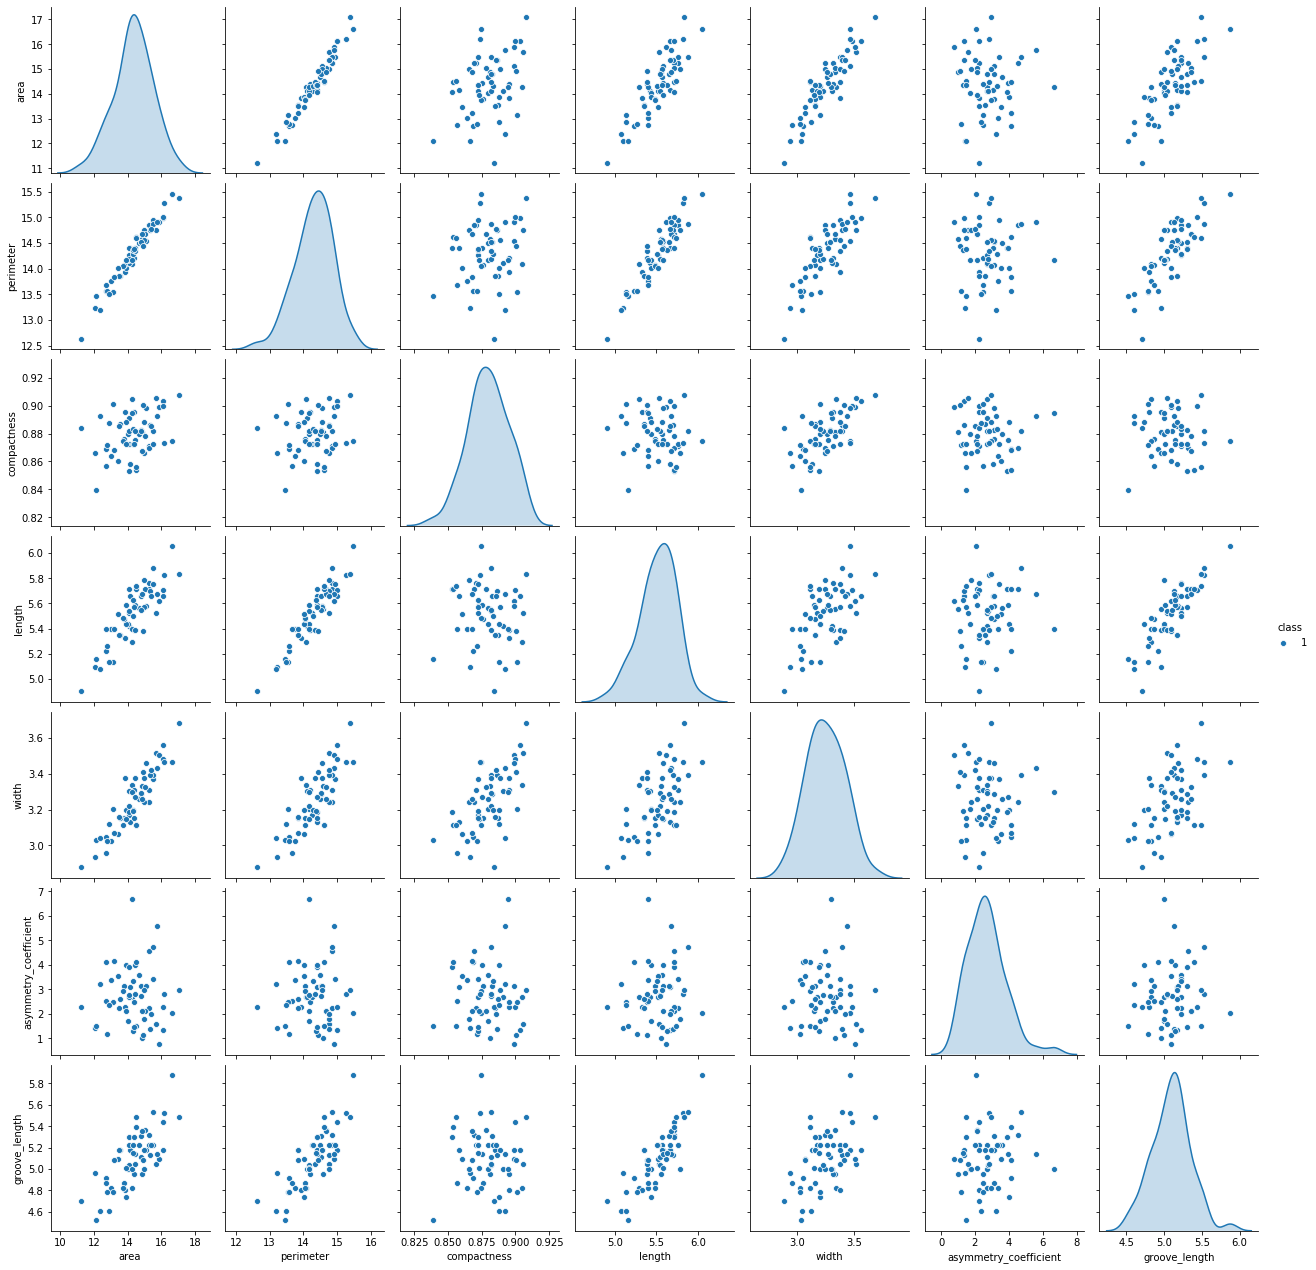

In [441]:
sns.pairplot(data=seeds_1,hue='class')

In [442]:
DF_Master.describe()

area   perimeter  compactness      length       width  \
count  185.000000  185.000000   185.000000  185.000000  185.000000   
mean    14.408865   14.334054     0.880751    5.522259    3.271151   
std      0.784544    0.370356     0.011838    0.169900    0.134343   
min     11.230000   12.630000     0.839200    4.902000    2.879000   
25%     14.030000   14.160000     0.872600    5.395000    3.168000   
50%     14.370000   14.370000     0.881100    5.527000    3.288000   
75%     14.880000   14.540000     0.888000    5.658000    3.377000   
max     17.080000   15.460000     0.907900    6.053000    3.683000   

       asymmetry_coefficient  groove_length  class  
count             185.000000     185.000000  185.0  
mean                2.768386       5.105546    1.0  
std                 1.076856       0.169740    0.0  
min                 0.765100       4.519000    1.0  
25%                 2.129000       5.001000    1.0  
50%                 2.700000       5.132000    1.0  
75%                 3.373000       5.178000    1.0  
max                 6.685000       5.877000    1.0

In [443]:
seeds_1.describe()

area  perimeter  compactness     length      width  \
count  59.000000  59.000000    59.000000  59.000000  59.000000   
mean   14.361864  14.310847     0.879849   5.518831   3.250576   
std     1.177497   0.559674     0.014918   0.221633   0.167295   
min    11.230000  12.630000     0.839200   4.902000   2.879000   
25%    13.760000  14.020000     0.871300   5.391500   3.139500   
50%    14.370000  14.390000     0.881100   5.545000   3.245000   
75%    15.080000  14.715000     0.889700   5.676000   3.377000   
max    17.080000  15.460000     0.907900   6.053000   3.683000   

       asymmetry_coefficient  groove_length  class  
count              59.000000      59.000000   59.0  
mean                2.709527       5.098169    1.0  
std                 1.142252       0.255650    0.0  
min                 0.765100       4.519000    1.0  
25%                 2.019500       4.956000    1.0  
50%                 2.688000       5.111000    1.0  
75%                 3.274000       5.223000    1.0  
max                 6.685000       5.877000    1.0